In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 81.7 MB/s eta 0:00:00:00:0100:01


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import os
import rasterio
from PIL import Image

In [28]:
# Define paths
image_folder = '/kaggle/input/water-seg-data/data/images'  
label_folder = '/kaggle/input/water-seg-data/data/labels'  

# Lists to store data
X = []
y = []

# Read all images
for filename in os.listdir(image_folder):
    if filename.endswith('.tif'):
        # Get corresponding label filename
        label_filename = filename.replace('.tif', '.png')
        
        # Read TIF file with all bands
        with rasterio.open(os.path.join(image_folder, filename)) as src:
            image = src.read()  # This will read all bands
            # Transpose from (C, H, W) to (H, W, C)
            image = np.transpose(image, (1, 2, 0))
            
        # Read PNG label
        label = np.array(Image.open(os.path.join(label_folder, label_filename)))
        # Convert label to binary
        label = (label > 0).astype(np.float32)
        
        X.append(image)
        y.append(label)

X = np.array(X)
y = np.array(y)

# Add channel dimension to labels
y = np.expand_dims(y, axis=-1)

print("Data shape:", X.shape)
print("Labels shape:", y.shape)

# Normalize the data
X_normalized = []
for i in range(X.shape[-1]):  #  12 channels
    channel = X[:,:,:,i]
    normalized_channel = (channel - channel.min()) / (channel.max() - channel.min())
    X_normalized.append(normalized_channel)
X = np.stack(X_normalized, axis=-1)

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Data shape: (306, 128, 128, 12)
Labels shape: (306, 128, 128, 1)


# **Data Splitting** #
# train 70%, val 15%, test 15%

In [29]:
# Split into train, validation, and test sets (70%, 15%, 15%)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (214, 128, 128, 12)
Validation set shape: (46, 128, 128, 12)
Test set shape: (46, 128, 128, 12)


# Visualizing

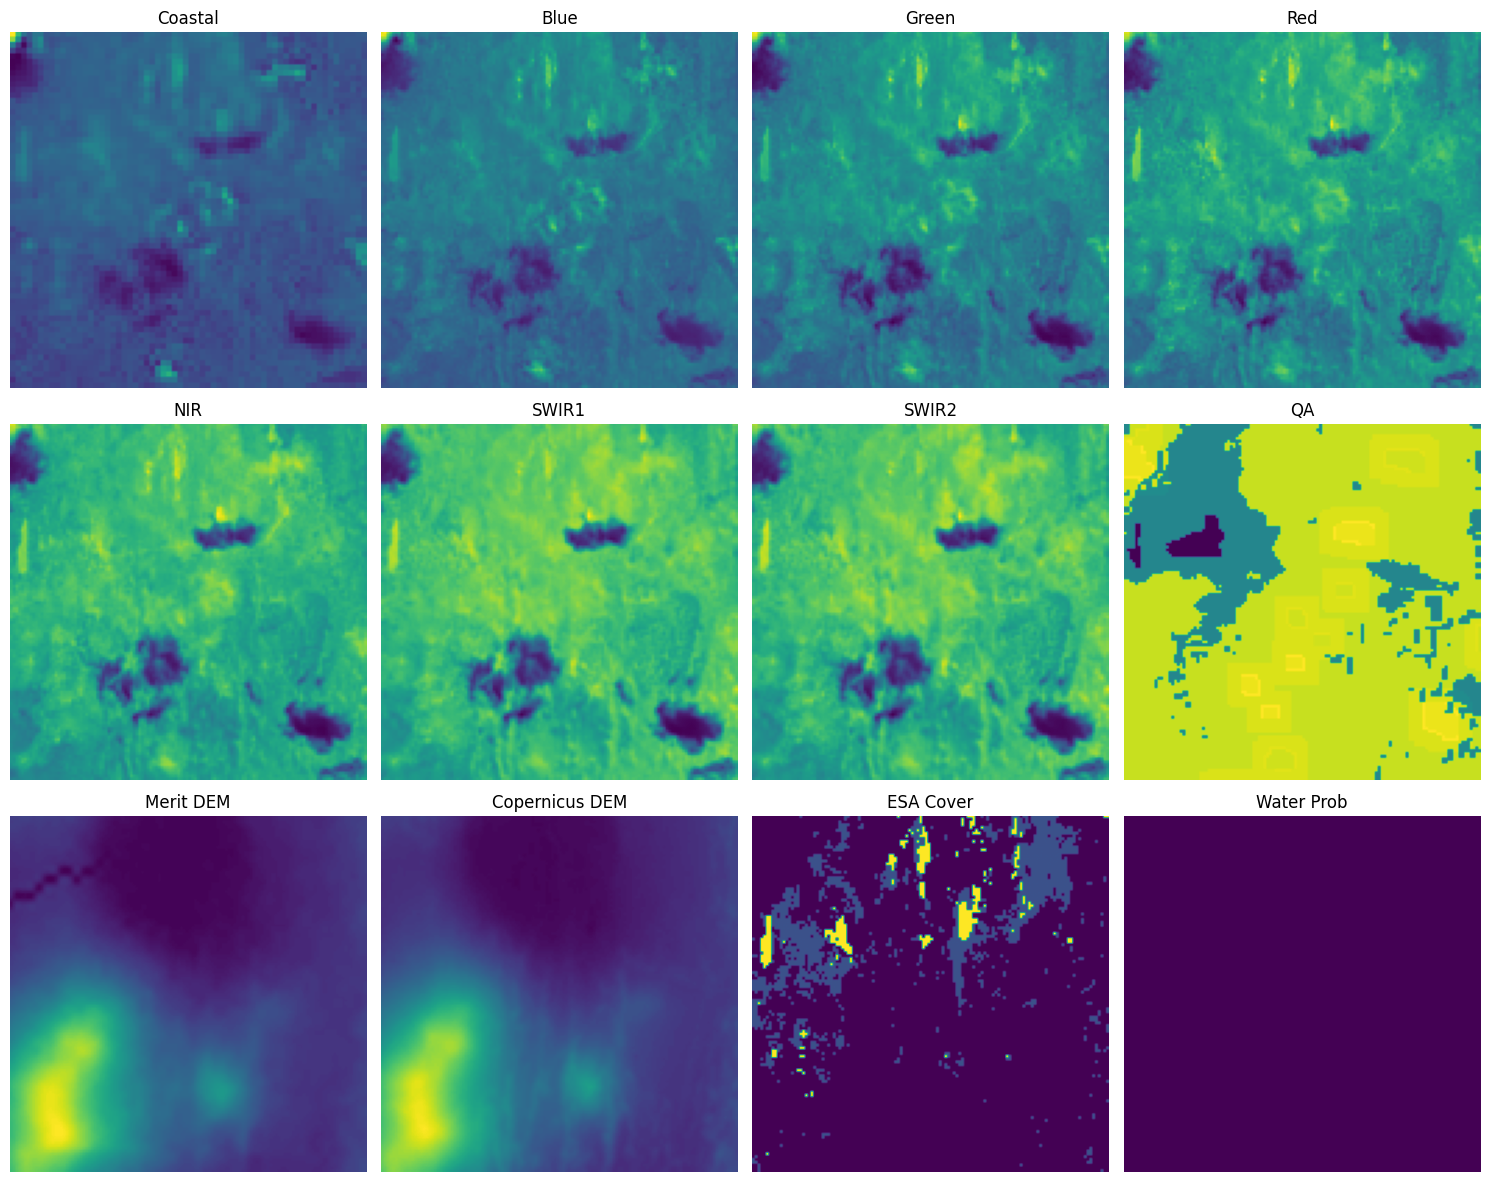

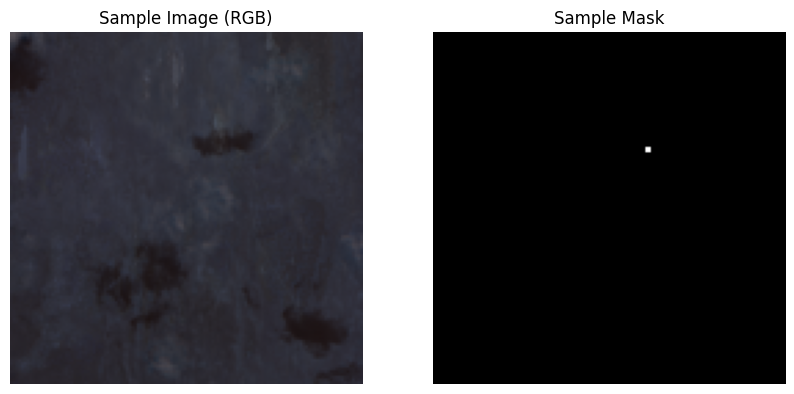

In [30]:
# Visualize all bands for a single sample
fig, axes = plt.subplots(3, 4, figsize=(15, 12))
band_names = ['Coastal', 'Blue', 'Green', 'Red', 'NIR', 'SWIR1', 
              'SWIR2', 'QA', 'Merit DEM', 'Copernicus DEM', 
              'ESA Cover', 'Water Prob']

for idx, (ax, name) in enumerate(zip(axes.flat, band_names)):
    ax.imshow(X_train[0,:,:,idx])
    ax.set_title(name)
    ax.axis('off')
plt.tight_layout()
plt.show()

# Visualize a sample image and its mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_train[0,:,:,1:4])  # RGB channels
plt.title('Sample Image (RGB)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(y_train[0,:,:,0], cmap='gray')
plt.title('Sample Mask')
plt.axis('off')
plt.show()

# U-Net Model Creation

In [31]:
# Input layer
inputs = Input(shape=(128, 128, 12))

# Encoder path
conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

# Bridge
conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

# Decoder path
up6 = Conv2DTranspose(512, 2, strides=(2,2), padding='same')(conv5)
merge6 = concatenate([conv4, up6], axis=3)
conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

up7 = Conv2DTranspose(256, 2, strides=(2,2), padding='same')(conv6)
merge7 = concatenate([conv3, up7], axis=3)
conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

up8 = Conv2DTranspose(128, 2, strides=(2,2), padding='same')(conv7)
merge8 = concatenate([conv2, up8], axis=3)
conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

up9 = Conv2DTranspose(64, 2, strides=(2,2), padding='same')(conv8)
merge9 = concatenate([conv1, up9], axis=3)
conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

# Output layer
outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

# Create model
model = Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])]
)

# Display model summary
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 128, 128, 12)   │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_57 (Conv2D)        │ (None, 128, 128, 64)   │          6,976 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_58 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_57[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 64, 64, 64)     │              0 │ conv2d_58[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_59 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_60 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_59[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 32, 32, 128)    │              0 │ conv2d_60[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_61 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_62 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_61[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 16, 16, 256)    │              0 │ conv2d_62[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_63 (Conv2D)        │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_64 (Conv2D)        │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_63[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_15          │ (None, 8, 8, 512)      │              0 │ conv2d_64[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_65 (Conv2D)        │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_15[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_66 (Conv2D)        │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_65[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_12       │ (None, 16, 16, 512)    │      2,097,664 │ conv2d_66[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_12       

 Total params: 31,036,929 (118.40 MB)

 Trainable params: 31,036,929 (118.40 MB)

 Non-trainable params: 0 (0.00 B)

# Model Training 

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5900 - io_u_3: 0.0000e+00 - loss: 0.6138 - val_accuracy: 0.8061 - val_io_u_3: 0.0000e+00 - val_loss: 0.4487
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 494ms/step - accuracy: 0.8292 - io_u_3: 0.0000e+00 - loss: 0.4409 - val_accuracy: 0.8375 - val_io_u_3: 0.0000e+00 - val_loss: 0.3605
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 492ms/step - accuracy: 0.8485 - io_u_3: 0.0000e+00 - loss: 0.3675 - val_accuracy: 0.8741 - val_io_u_3: 0.0000e+00 - val_loss: 0.3007
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 483ms/step - accuracy: 0.8922 - io_u_3: 0.0000e+00 - loss: 0.2954 - val_accuracy: 0.9124 - val_io_u_3: 0.0000e+00 - val_loss: 0.2727
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - accuracy: 0.9022 - io_u_3: 0.0000e+00 - loss: 0.2770 - val_accuracy: 0.8840 - val_io_u_3: 0.0000e+00 - val_loss: 0.3134
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 504ms/step - accuracy: 0.8898 - io_u_3: 0.0000e+00 - loss: 0.2911 - val_accuracy: 0.9185 - val_io_u_3: 

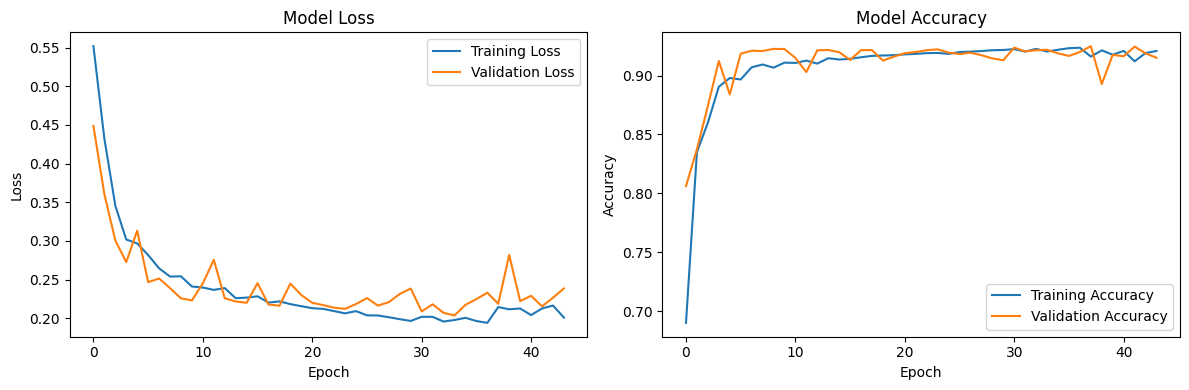

In [32]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[
        EarlyStopping(patience=10),
        ModelCheckpoint('best_model.keras', save_best_only=True)  
    ]
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
IoU Score: 0.6889
Precision: 0.8629
Recall: 0.7736
F1-Score: 0.8158


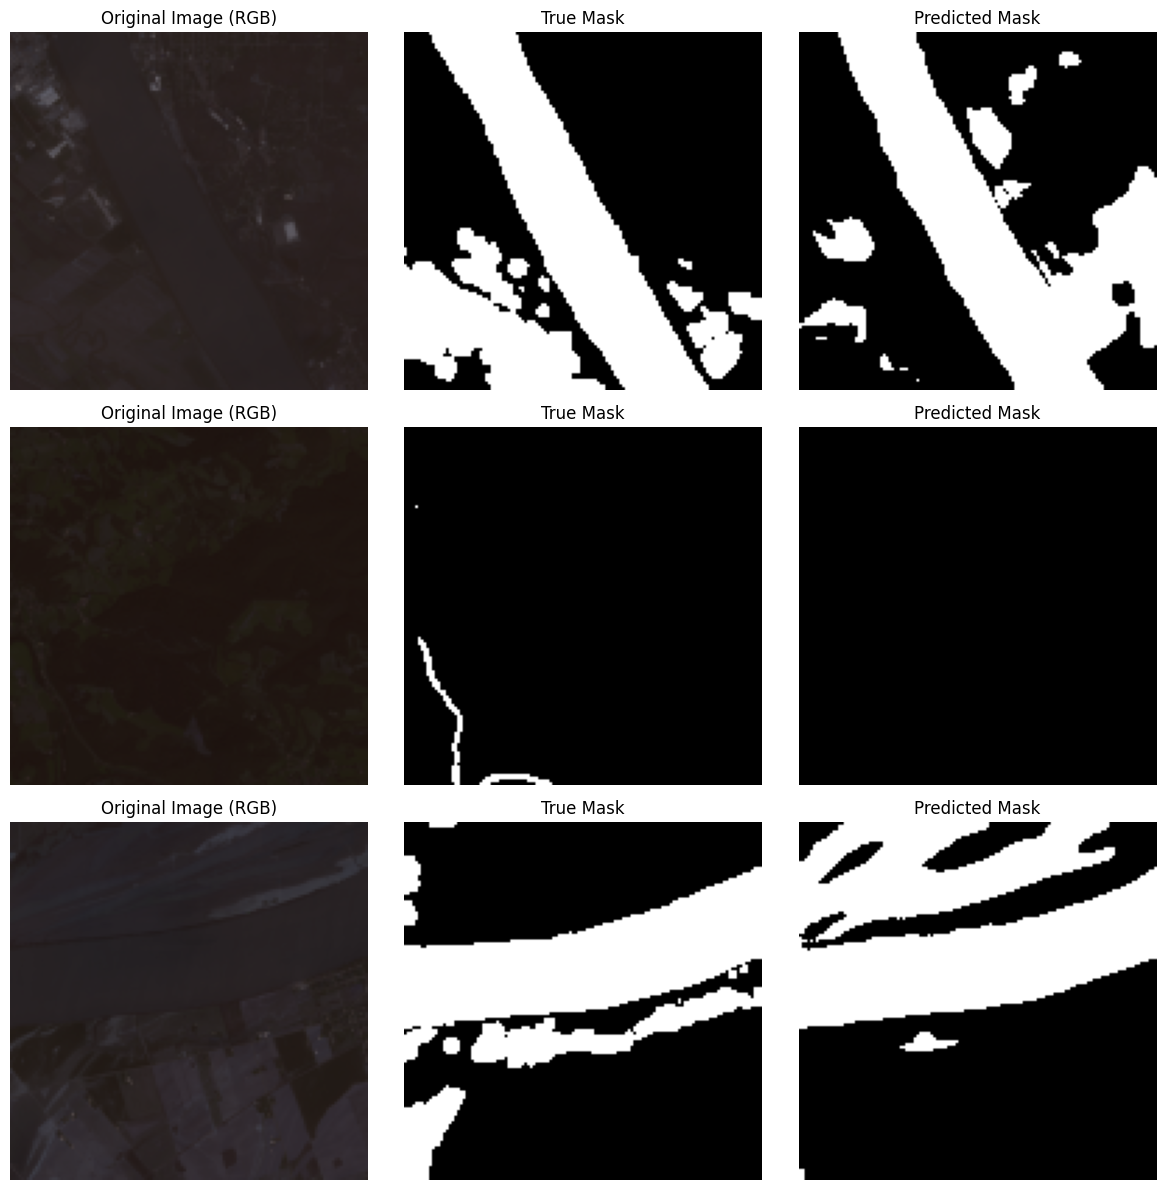

In [34]:
# Make predictions on test set
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(np.uint8)

# Calculate metrics
iou_score = jaccard_score(y_test.flatten(), predictions.flatten())
precision = precision_score(y_test.flatten(), predictions.flatten())
recall = recall_score(y_test.flatten(), predictions.flatten())
f1 = f1_score(y_test.flatten(), predictions.flatten())

# Print results
print(f'IoU Score: {iou_score:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Visualize some predictions
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for i in range(3):
    # Original image (showing RGB channels)
    axes[i,0].imshow(X_test[i,:,:,1:4])  # RGB channels
    axes[i,0].set_title('Original Image (RGB)')
    axes[i,0].axis('off')
    
    # True mask
    axes[i,1].imshow(y_test[i,:,:,0], cmap='gray')
    axes[i,1].set_title('True Mask')
    axes[i,1].axis('off')
    
    # Predicted mask
    axes[i,2].imshow(predictions[i,:,:,0], cmap='gray')
    axes[i,2].set_title('Predicted Mask')
    axes[i,2].axis('off')

plt.tight_layout()
plt.show()